# XGBoost Parameter Tuning for Rent Listing Inqueries

## 1. 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

首先 import 必要的模块

In [186]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,train_test_split

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [187]:
# path to where the data lies
dpath = './data/'
train = xgb.DMatrix(dpath +"RentListingInquries_FE_train.bin")
test = xgb.DMatrix(dpath +"RentListingInquries_FE_test.bin")
#train.head()

In [188]:
train.num_col()

227

In [189]:
train.num_row()

1000

In [190]:
X_train=train
y_train=train.get_label()

In [191]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

默认参数，此时学习率为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [192]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train,y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train,y_train,eval_metric='mlogloss')
    print(n_estimators)
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

   #Print model report:
    print ("logloss of train :" )
    print(logloss)

In [193]:
params ={'n_estimators':1000,  #数值大没关系，cv会自动返回合适的n_estimators
        'objective':'multi:softprob',
        'seed':3,
        'num_class':3,
        'eval_metric':'mlogloss',
        'nthread':-1,
        'booster':'gbtree'}


cvresult = xgb.cv(params, train, num_boost_round=10000, folds =kfold)
  
cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
#最佳参数n_estimators
n_estimators = cvresult.shape[0]
print(n_estimators)


10000


In [166]:
from xgboost import plot_importance
plot_importance(xgb)
pyplot.show()

ValueError: tree must be Booster, XGBModel or dict instance

In [167]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

KeyError: 'test-mlogloss-mean'

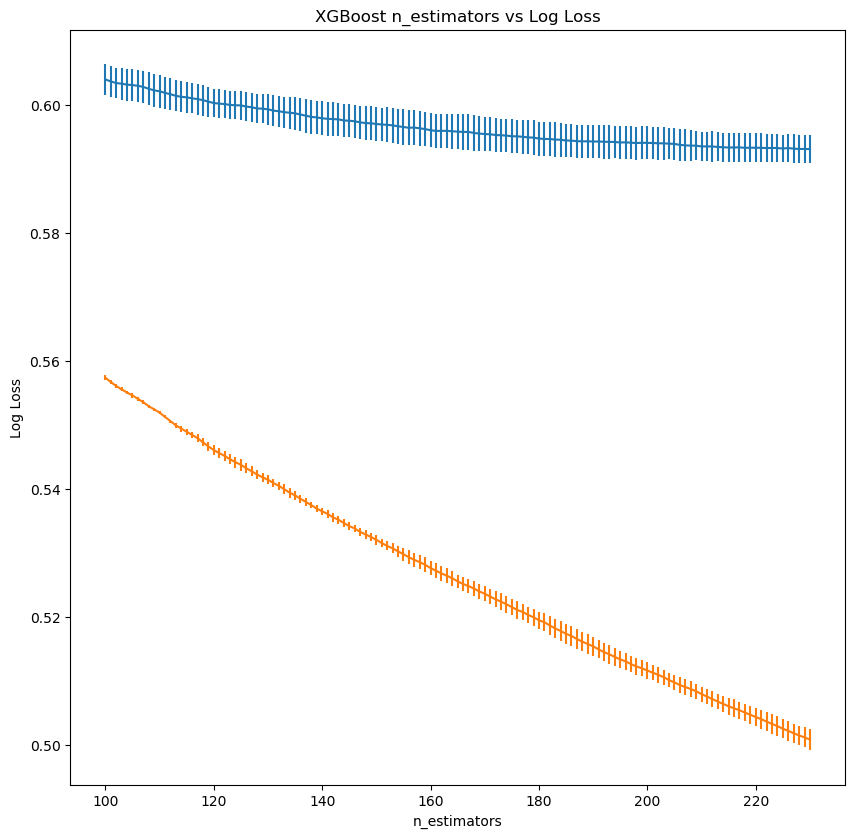

In [136]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()